In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

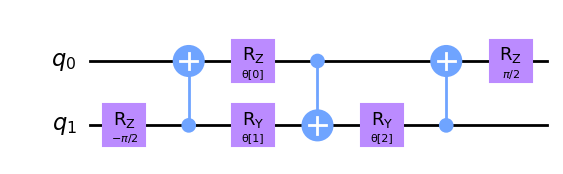

In [30]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

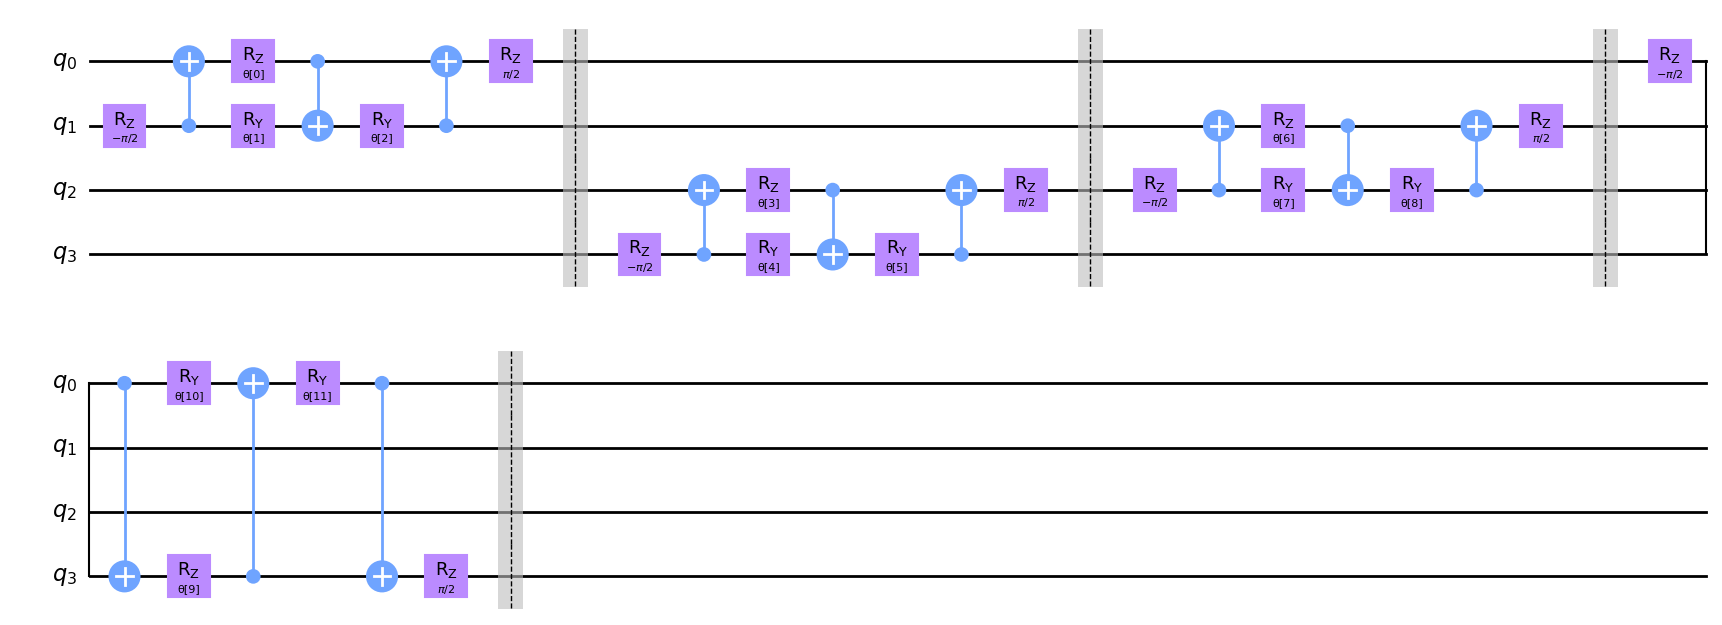

In [31]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

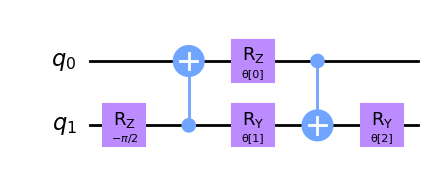

In [32]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

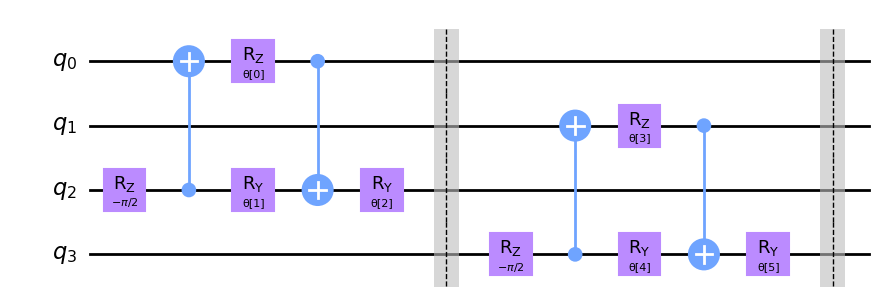

In [33]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [34]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


In [39]:
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert 1 channel to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

BATCH_SIZE=64

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download,size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=data_transform, download=download,size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=data_transform, download=download,size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\rezua\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\rezua\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\rezua\.medmnist\breastmnist_224.npz


In [87]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)


# Remove the average pooling and fully connected layers
model = torch.nn.Sequential(*list(model.children())[:-2])

# Add a Conv2d layer to reduce features to 8 dimensions
model.add_module('conv2d', torch.nn.Conv2d(2048, 8, kernel_size=7, stride=7))



# Set the model to evaluation mode
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [93]:
# Function to extract features and labels from the dataset
def extract_features_labels(dataloader, model):
    features_list = []
    labels_list = []
    
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Extracting Features and Labels"):
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')

            # Get features from the penultimate layer (before the new FC layer)
            outputs = model(inputs)
            features = outputs.squeeze()
            features_list.append(features.cpu())
            labels_list.append(labels)

    # Concatenate all features and labels into numpy arrays
    all_features = torch.cat(features_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)
    
    return all_features.numpy(), all_labels.numpy()

In [94]:

# Extract features and labels from the dataset
train_features, train_labels = extract_features_labels(train_loader, model)

# Flatten labels if needed (assuming train_labels is a tensor of shape [num_samples, 1])
train_labels_flat = train_labels.flatten()

print("Extracted features shape:", train_features.shape)


Extracting Features and Labels: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

Extracted features shape: (546, 8)


In [95]:
# # # Calculate the dimensionality of the dataset
# dimensionality = train_features.shape[1]  # Number of columns represents the dimensionality
# print("Dimensionality of the dataset:", dimensionality)

In [49]:
# from sklearn.decomposition import PCA
# import seaborn as sns

# # Reduce dimensionality to 8 components using PCA
# train_features = PCA(n_components=8).fit_transform(train_images_scaled)

# # Set the figure size
# plt.rcParams["figure.figsize"] = (6, 6)

# # Scatter plot of the first two principal components
# sns.scatterplot(x=train_features[:, 0], y=train_features[:, 1], hue=train_labels_flat, palette="tab10")

# plt.show()


In [50]:
# from sklearn.decomposition import PCA
# import seaborn as sns

# # Reduce dimensionality to 8 components using PCA
# test_features = PCA(n_components=8).fit_transform(test_images_scaled)

# # Set the figure size
# plt.rcParams["figure.figsize"] = (6, 6)

# # Scatter plot of the first two principal components
# sns.scatterplot(x=test_features[:, 0], y=test_features[:, 1], hue=test_labels_flat, palette="tab10")

# plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# from qiskit_algorithms.utils import algorithm_globals

# algorithm_globals.random_seed = 123
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
# )

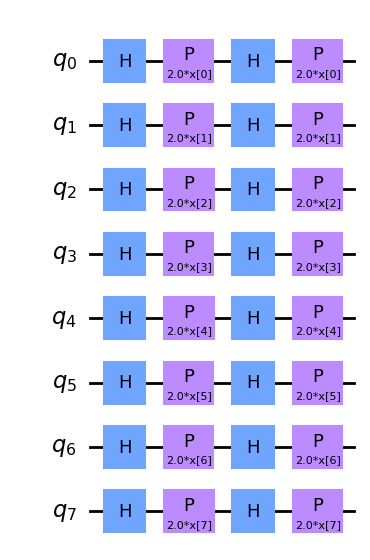

In [96]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [97]:

feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

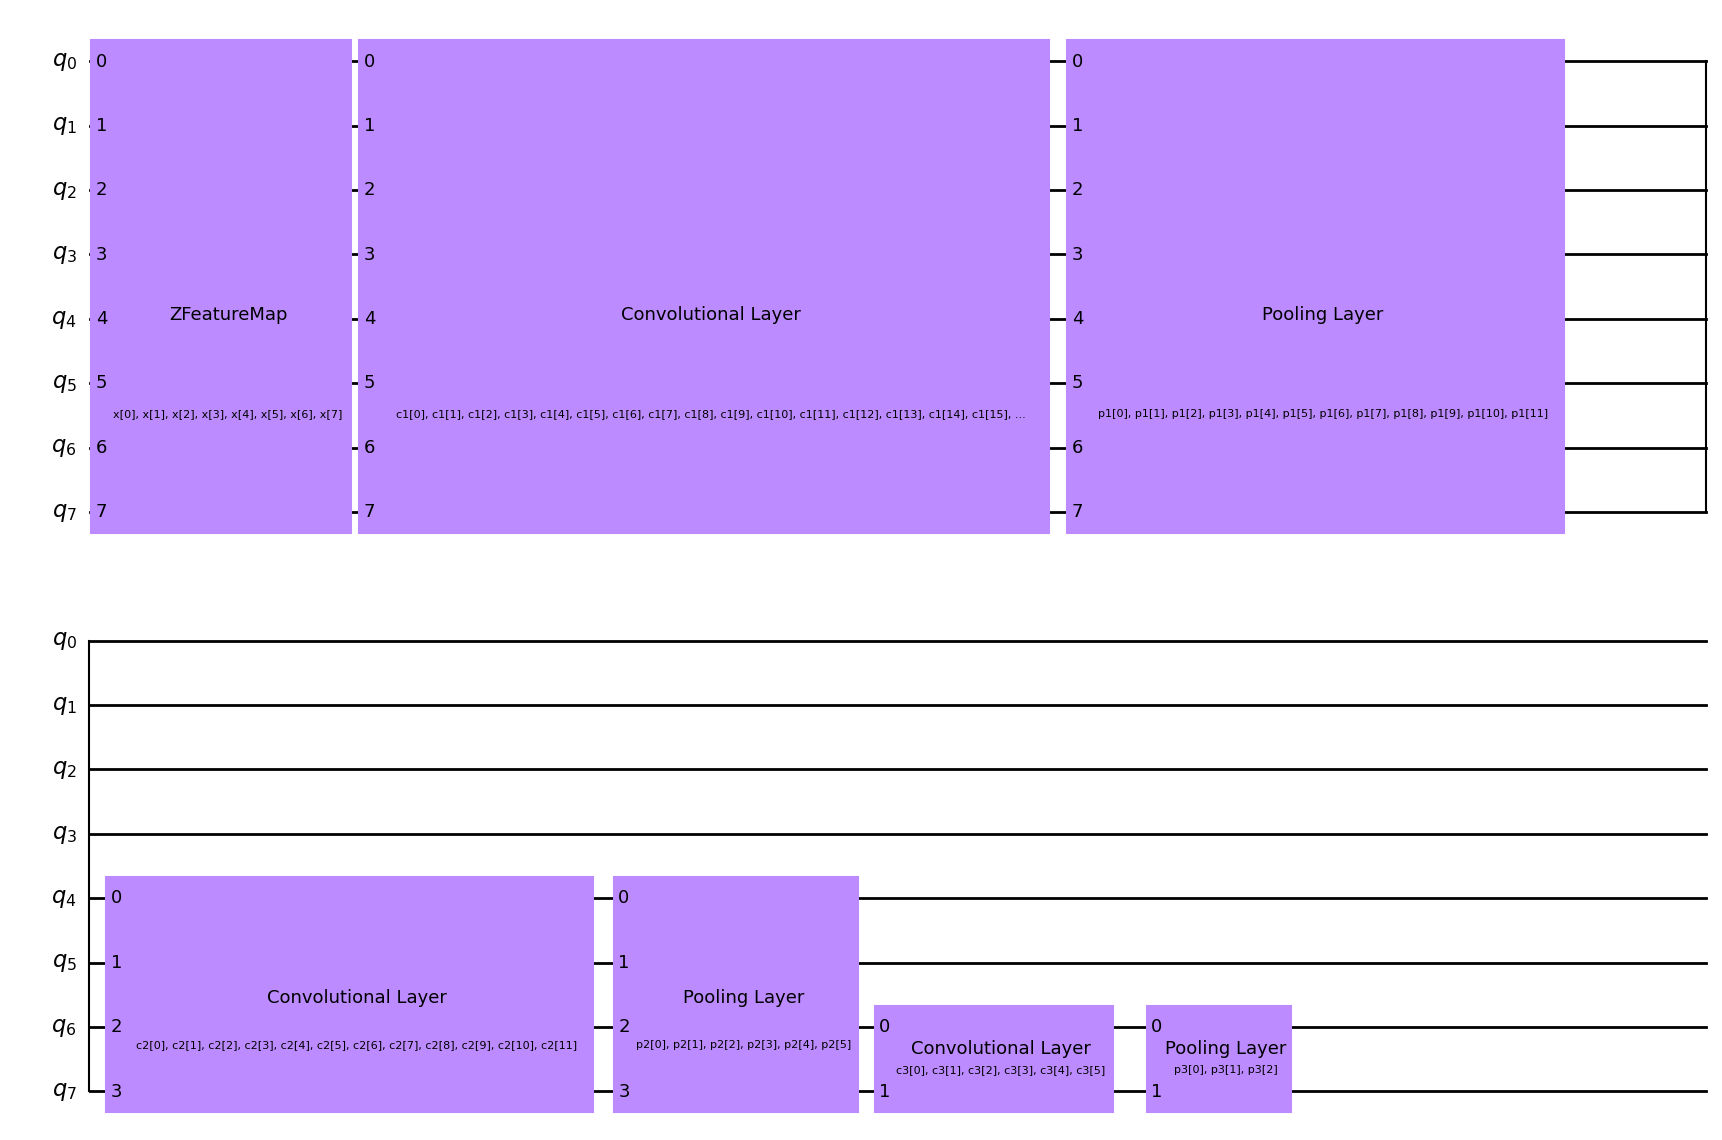

In [98]:
circuit.draw("mpl", style="clifford")

In [99]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [100]:


classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=50),  # Set max iterations here
    callback=callback_graph
)

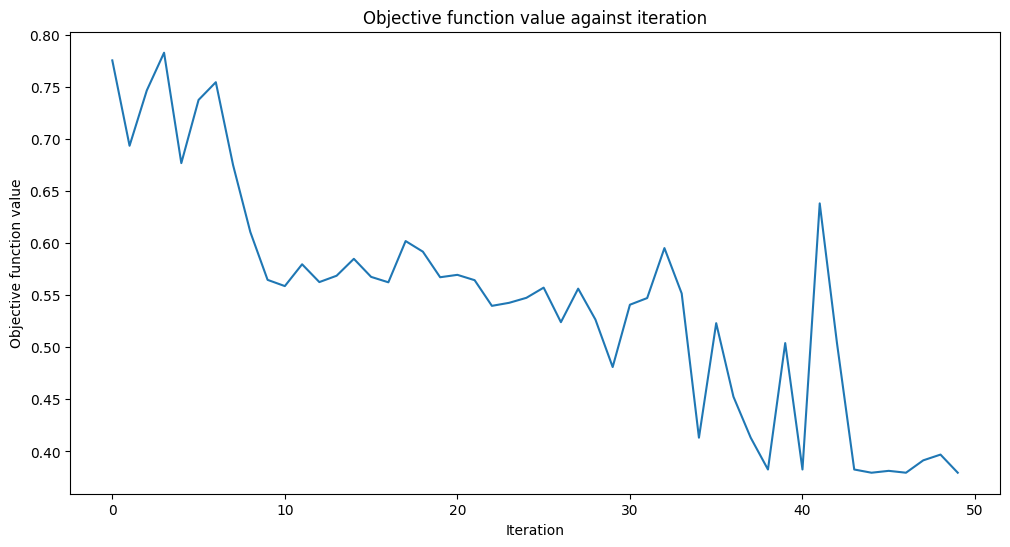

Accuracy from the train data : 71.43%


In [101]:
x = np.asarray(train_features)
y = np.asarray(train_labels_flat)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [102]:
# Extract features and labels from the dataset
test_features, test_labels = extract_features_labels(test_loader, model)

# Flatten labels if needed (assuming train_labels is a tensor of shape [num_samples, 1])
test_labels_flat = test_labels.flatten()

print("Extracted features shape:", test_features.shape)

Extracting Features and Labels: 100%|██████████| 2/2 [00:17<00:00,  8.53s/it]

Extracted features shape: (156, 8)


In [103]:
y_predict = classifier.predict(test_features)
x = np.asarray(test_features)
y = np.asarray(test_labels_flat)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")



Accuracy from the test data : 71.79%


In [112]:

import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Load the pretrained ResNet-50 model
model2 = models.resnet50(pretrained=True)


# Remove the average pooling and fully connected layers
model2 = torch.nn.Sequential(*list(model.children())[:-1])


model2.fc = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Apply global average pooling
)

# Set the model to evaluation mode
model2.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [113]:
# Extract features and labels from the dataset
train_features2, train_labels2 = extract_features_labels(train_loader, model2)

# Flatten labels if needed (assuming train_labels is a tensor of shape [num_samples, 1])
train_labels_flat2 = train_labels2.flatten()

print("Extracted features shape:", train_features2.shape)


Extracting Features and Labels: 100%|██████████| 9/9 [00:47<00:00,  5.24s/it]

Extracted features shape: (546, 2048)


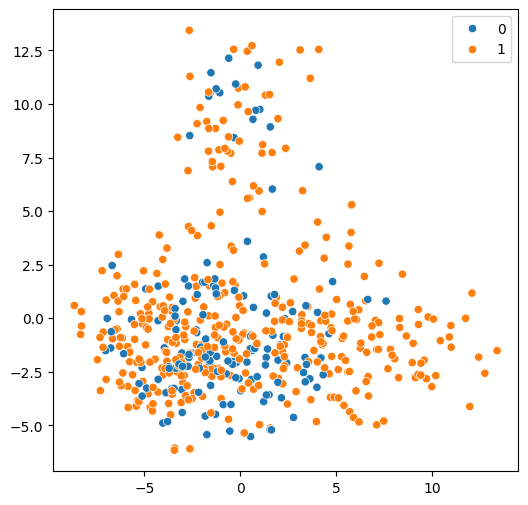

In [115]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensionality to 8 components using PCA
train_features2_pca = PCA(n_components=8).fit_transform(train_features2)

# Set the figure size
plt.rcParams["figure.figsize"] = (6, 6)

# Scatter plot of the first two principal components
sns.scatterplot(x=train_features2_pca[:, 0], y=train_features2_pca[:, 1], hue=train_labels_flat2, palette="tab10")

plt.show()


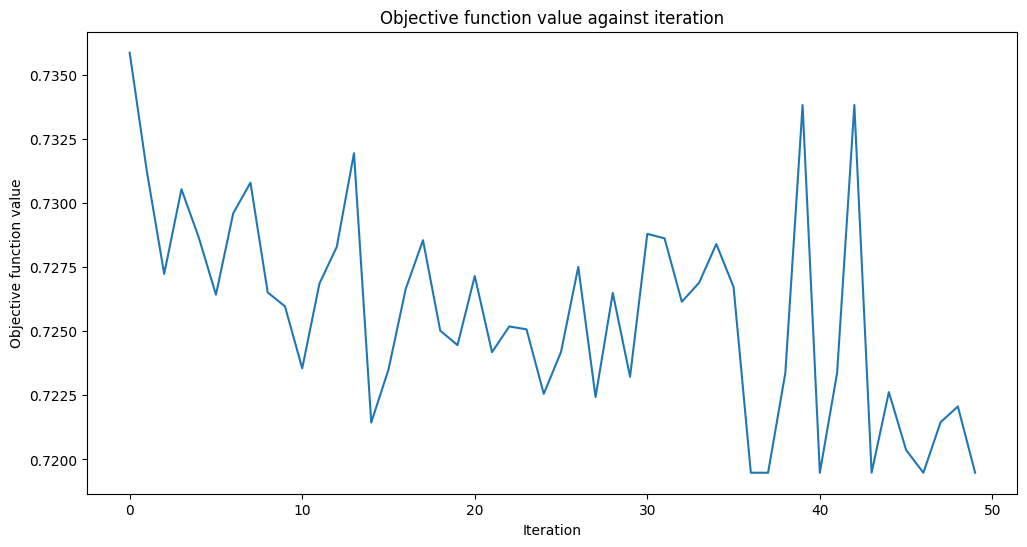

Accuracy from the train data : 39.74%


In [116]:
x = np.asarray(train_features2_pca)
y = np.asarray(train_labels_flat2)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [117]:
# Extract features and labels from the dataset
test_features2, test_labels2 = extract_features_labels(test_loader, model2)

# Flatten labels if needed (assuming train_labels is a tensor of shape [num_samples, 1])
test_labels_flat2 = test_labels2.flatten()

print("Extracted features shape:", test_features2.shape)

Extracting Features and Labels: 100%|██████████| 2/2 [00:13<00:00,  6.82s/it]

Extracted features shape: (156, 2048)


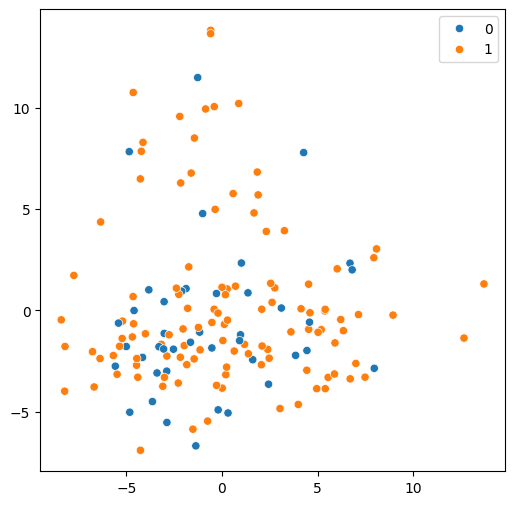

In [118]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensionality to 8 components using PCA
test_features2_pca = PCA(n_components=8).fit_transform(test_features2)

# Set the figure size
plt.rcParams["figure.figsize"] = (6, 6)

# Scatter plot of the first two principal components
sns.scatterplot(x=test_features2_pca[:, 0], y=test_features2_pca[:, 1], hue=test_labels_flat2, palette="tab10")

plt.show()

In [119]:
y_predict = classifier.predict(test_features2_pca)
x = np.asarray(test_features2_pca)
y = np.asarray(test_labels_flat2)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")


Accuracy from the test data : 40.38%
